In [1]:
import os
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.append('../src')
sys.path.append('../../src')
from Library import VerboseLibrary
import matplotlib.colors as mcolors

named_colors = list(mcolors.TABLEAU_COLORS) * 3

device = 'cpu'#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load Models

In [2]:
model_names = sorted(os.listdir('./models_R'))
len(model_names)

10

In [3]:
model_coefficient_history = {}
model_coefficient_mask = {}
model_coefficients = {}

for name in tqdm(model_names):
    model = torch.load(os.path.join('.', 'models_R', name)).to(device)
    model_coefficient_history[name] = np.array(model.coefficient_history)
    model_coefficients[name] = np.array(model.coefficient_mask.detach().cpu().numpy() * model.coefficients.detach().cpu().numpy())
    model_coefficient_mask[name] = np.array(model.coefficient_mask)

100%|██████████| 10/10 [00:03<00:00,  2.72it/s]


In [13]:
model_coefficient_mask[model_names[1]][[1, 2], :].sum()

2

In [25]:
model_linear_detected = {name:
    model_coefficient_mask[name][[1, 2], :].sum() == 2
    and not model_coefficient_mask[name][[i for i in range(12) if i not in [1, 2]], :].any() for name in model_names}
model_nonlinear_detected = {name:
    not model_linear_detected[name]
    and model_coefficient_mask[name][[1, 2, 10, 11], :].sum() == 2
    and not model_coefficient_mask[name][[i for i in range(12) if i not in [1, 2, 10, 11]], :].any() for name in model_names}
model_other_detected = {name:
    not model_linear_detected[name]
    and not model_nonlinear_detected[name]
    for name in model_names}

In [27]:
for name in model_names:
    print(model_linear_detected[name], model_nonlinear_detected[name], model_other_detected[name])

False True False
True False False
False True False
False True False
False False True
False False True
False True False
False True False
True False False
False False True


# Coefficients

In [6]:
masked_coefficient_list = np.array([model_coefficients[name].round(2) for name in model_names], dtype=object)

In [7]:
masked_coefficient_list[masked_coefficient_list == 0] = '-'

In [8]:
pd.DataFrame(masked_coefficient_list[:, :, 0], columns=['*'.join(l) for l in VerboseLibrary(model.library).build_verbose()])

1 z_1   z_2 z_1*z_1 z_1*z_2 z_2*z_2 z_1*z_1*z_1 z_1*z_1*z_2 z_1*z_2*z_2  \
0     -   -     -       -       -       -           -           -           -   
1     -   -  0.92       -       -       -           -           -           -   
2     -   -  0.87       -       -       -           -           -           -   
3     -   -     -       -       -       -           -           -           -   
4     -   -     -       -       -    0.23           -           -           -   
5 -0.44   -     -       -       -     0.9           -           -           -   
6     -   -     -       -       -       -           -           -           -   
7     -   -     -       -       -       -           -           -           -   
8     -   -  0.86       -       -       -           -           -           -   
9     -   -     -       -       -       -           -        0.64           -   

  z_2*z_2*z_2 sin(z_1) sin(z_2)  
0           -        -    -1.05  
1           -        -        -  
2           -        -        -  
3           -        -    -1.13  
4           -        -        -  
5           -        -        -  
6           -        -    -0.97  
7           -        -    -1.05  
8           -        -        -  
9           -        -        -

In [9]:
pd.DataFrame(masked_coefficient_list[:, :, 1], columns=['*'.join(l) for l in VerboseLibrary(model.library).build_verbose()])

1   z_1 z_2 z_1*z_1 z_1*z_2 z_2*z_2 z_1*z_1*z_1 z_1*z_1*z_2 z_1*z_2*z_2  \
0     -  0.91   -       -       -       -           -           -           -   
1     -  -0.9   -       -       -       -           -           -           -   
2     -     -   -       -       -       -           -           -           -   
3     -  0.77   -       -       -       -           -           -           -   
4     -  1.45   -       -       -       -           -           -           -   
5     -  0.66   -       -       -       -           -           -           -   
6     -  0.98   -       -       -       -           -           -           -   
7     -  0.95   -       -       -       -           -           -           -   
8     - -0.96   -       -       -       -           -           -           -   
9 -0.17     -   -       -       -       -           -           -           -   

  z_2*z_2*z_2 sin(z_1) sin(z_2)  
0           -        -        -  
1           -        -        -  
2           -    -1.04        -  
3           -        -        -  
4           -        -        -  
5           -        -        -  
6           -        -        -  
7           -        -        -  
8           -        -        -  
9           -        -        -

# Only Sin Curves

In [35]:
model_linear_history = {name: model_coefficient_history[name][:, [1, 2], :] for name in model_names}
model_other_history = {name: model_coefficient_history[name][:, [i for i in range(12) if i not in [1, 2]], :] for name in model_names}

100%|██████████| 10/10 [00:00<00:00, 115.68it/s]


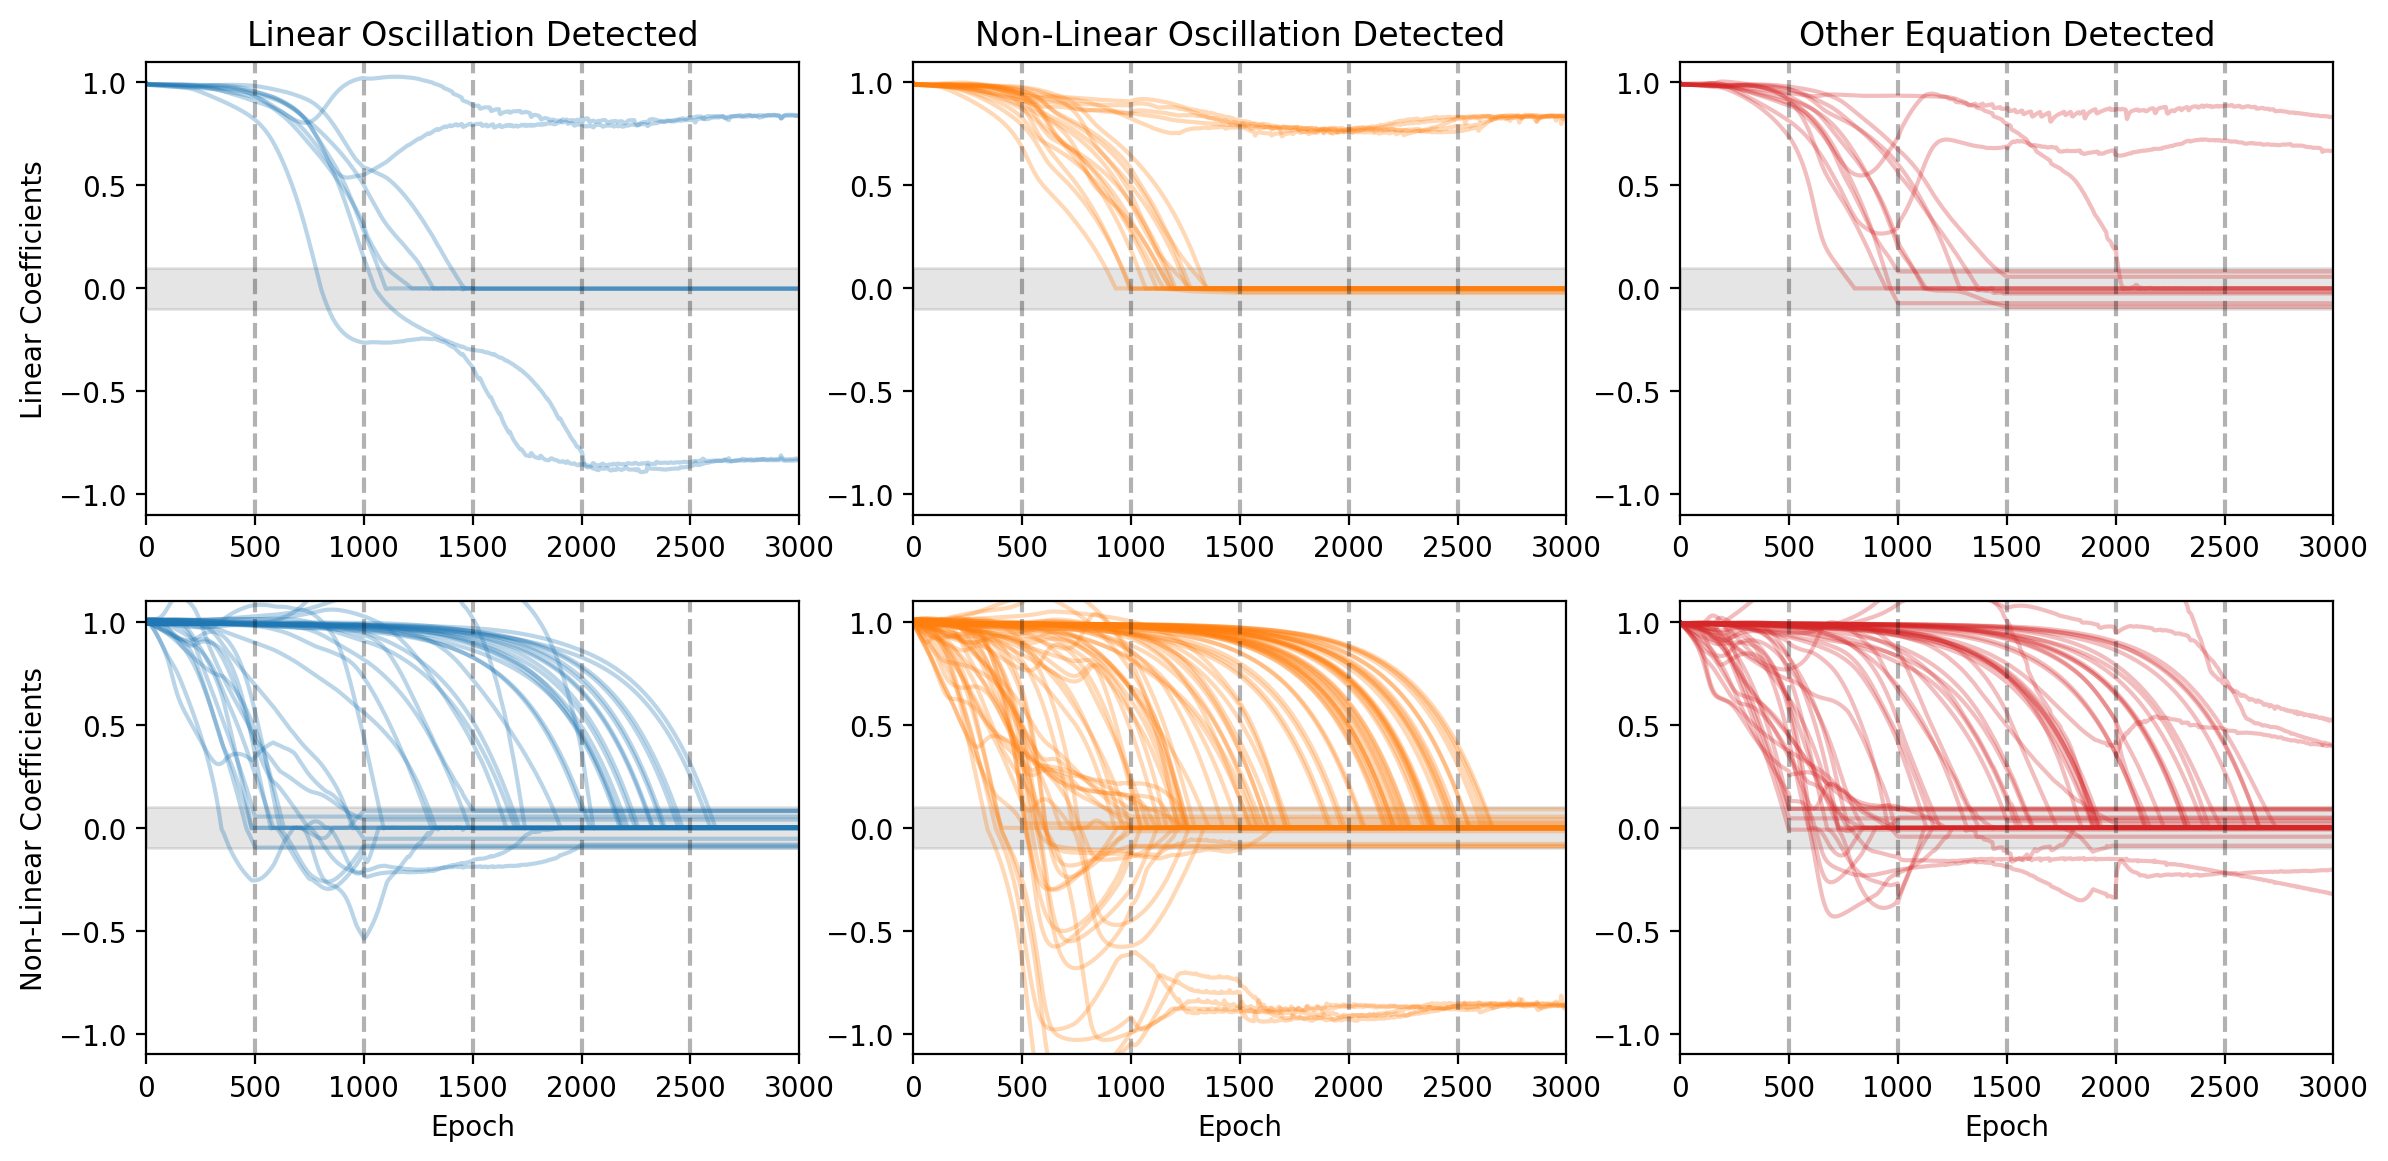

In [36]:
fig, axes = plt.subplots(2, 3, figsize=(21/1.8, 10/1.8), dpi=200)
fig.tight_layout(w_pad=1, h_pad=1)
xlim = 3000

alpha = 0.3

for name in tqdm(model_names):
    for i in range(2):
        if model_linear_detected[name]:
            axes[0][0].plot(model_linear_history[name][:xlim, i], color='tab:blue', alpha=alpha);
            axes[1][0].plot(model_other_history[name][:xlim, :, i], color='tab:blue', alpha=alpha);
        elif model_nonlinear_detected[name]:
            axes[0][1].plot(model_linear_history[name][:xlim, i], color='tab:orange', alpha=alpha);
            axes[1][1].plot(model_other_history[name][:xlim, :, i], color='tab:orange', alpha=alpha);
        else:
            axes[0][2].plot(model_linear_history[name][:xlim, i], color='tab:red', alpha=alpha);
            axes[1][2].plot(model_other_history[name][:xlim, :, i], color='tab:red', alpha=alpha);

axes[0][0].set_title(f'Linear Oscillation Detected');
axes[0][1].set_title(f'Non-Linear Oscillation Detected');
axes[0][2].set_title(f'Other Equation Detected');

axes[0][0].set_ylabel('Linear Coefficients');
axes[1][0].set_ylabel('Non-Linear Coefficients');

for ax in axes[0]:
    ax.set_xlim(0, xlim); ax.axhspan(-0.1, 0.1, color='black', alpha=0.1);
    for threshold_epoch in np.arange(500, xlim, 500): ax.axvline(threshold_epoch, color='black', alpha=0.3, linestyle='--'); ax.set_ylim(-1.1, 1.1)

for ax in axes[1]:
    ax.set_xlim(0, xlim); ax.set_xlabel('Epoch'); ax.axhspan(-0.1, 0.1, color='black', alpha=0.1);
    for threshold_epoch in np.arange(500, xlim, 500): ax.axvline(threshold_epoch, color='black', alpha=0.3, linestyle='--'); ax.set_ylim(-1.1, 1.1)

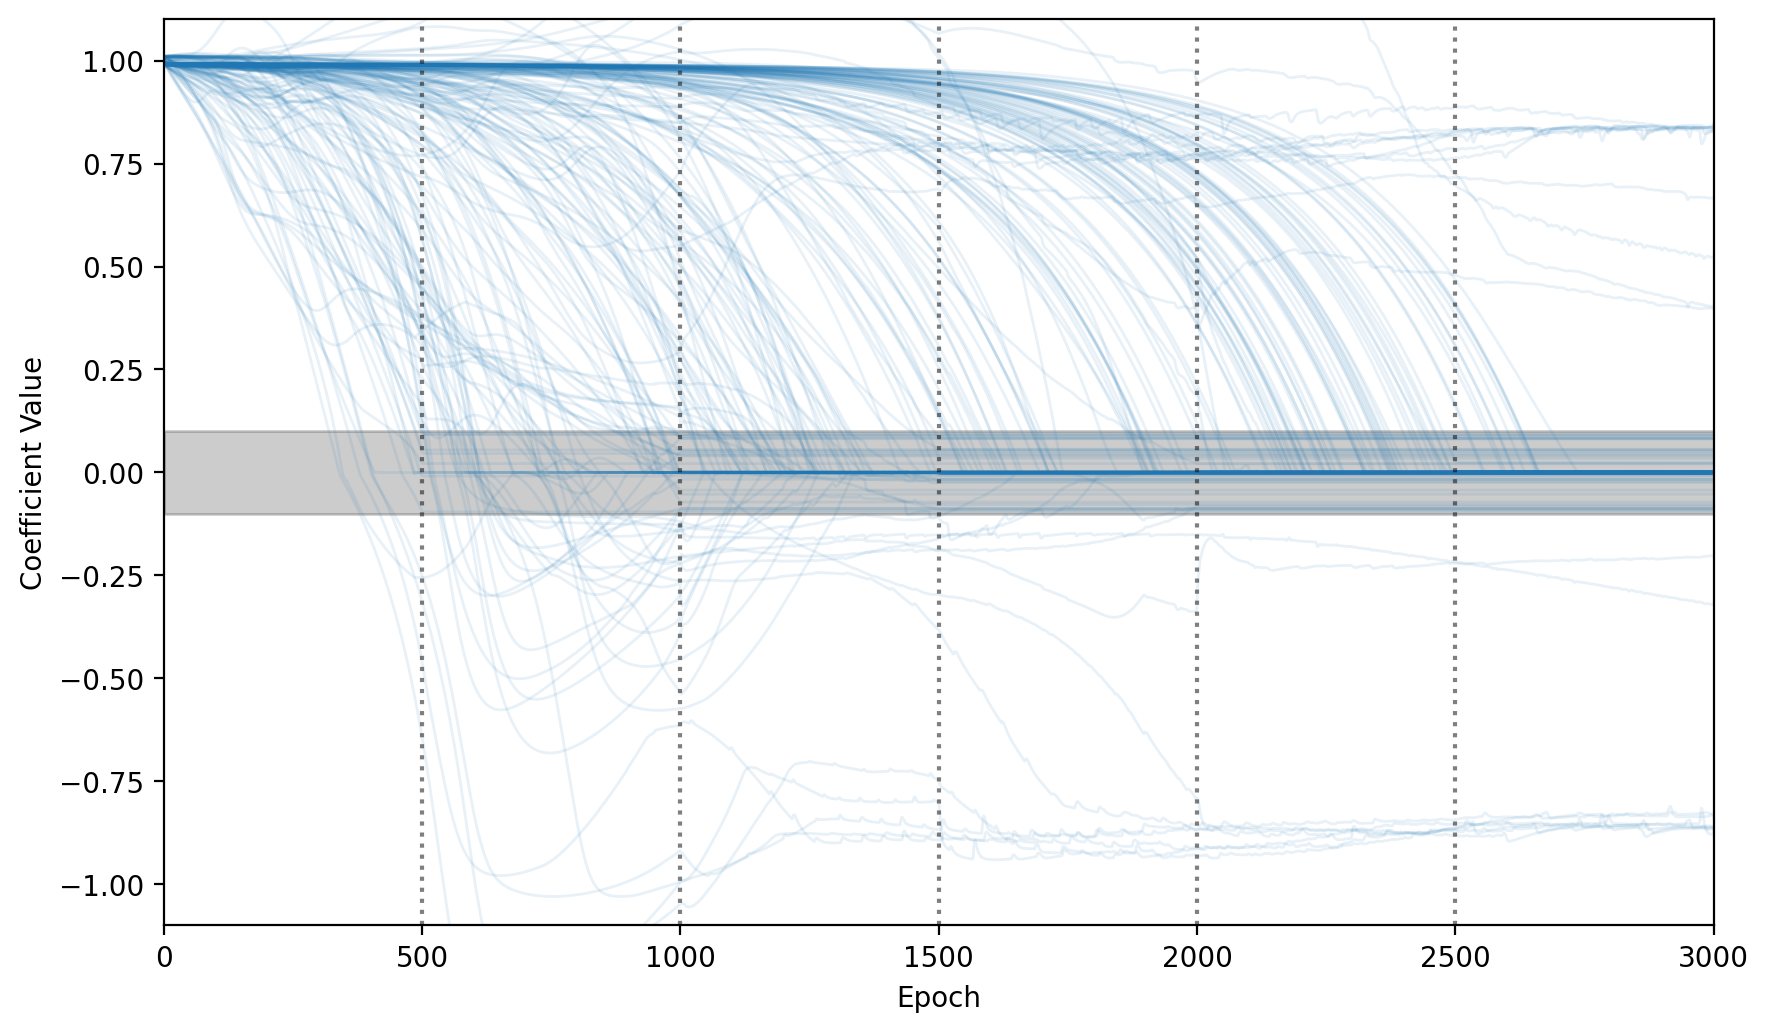

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=200)
for coefficient_history in model_coefficient_history.values():
    for i in range(12):
        for j in range(2):
            ax.plot(np.arange(coefficient_history.shape[0]), coefficient_history[:, i, j], color='tab:blue', alpha=0.1, linewidth=1)
ax.set_xlim(0, 3000); ax.set_ylim(-1.1, 1.1); ax.set_xlabel('Epoch'); ax.set_ylabel('Coefficient Value');
ax.axhspan(-0.1, 0.1, color='black', alpha=0.2); 
for threshold_epoch in np.arange(500, 3000, 500): ax.axvline(threshold_epoch, color='black', alpha=0.5, linestyle=':')

# Thresholding

In [13]:
def trend(a, lengthscale=5):
    mean_diff_last_values, var_last_values = np.mean(a[-2*lengthscale:-lengthscale], axis=0), np.var(a[-2*lengthscale:-lengthscale], axis=0)
    mean_diff_now_values, var_now_values = np.mean(a[-lengthscale:], axis=0), np.var(a[-lengthscale:], axis=0)
    return mean_diff_now_values - mean_diff_last_values, np.sqrt(var_last_values + var_now_values)

In [14]:
def trend_speed(a, lengthscale=5):
    if a.shape[0] > 2*lengthscale:
        return trend(a, lengthscale)[0]
    return np.zeros(a.shape[1:])

In [15]:
def trend_significance(a, lengthscale=5):
    if a.shape[0] > 2*lengthscale:
        t = trend(a, lengthscale)
        r = np.copy(t[0])
        r[(t[0] != 0) & (t[1] == 0)] = np.nan
        r[(t[0] != 0) & (t[1] != 0)] = t[0][(t[0] != 0) & (t[1] != 0)] / t[1][(t[0] != 0) & (t[1] != 0)]
        return r
    return np.zeros(a.shape[1:])

In [16]:
model_trend_significances = {}
model_trend_speed = {}
for name in model_names:
    model_trend_significances[name] = np.stack([trend_significance(model_coefficient_history[name][:i]) for i in range(6000)])
    model_trend_speed[name] = np.stack([trend_speed(model_coefficient_history[name][:i]) for i in range(6000)])

In [17]:
threshold_trial_epochs = np.arange(0, 3001, 500)

In [18]:
model_coefficient_activity_history = {name: (model_coefficient_history[name][threshold_trial_epochs + 20] - model_coefficient_history[name][threshold_trial_epochs + 19]).astype(bool) for name in model_names}
model_thresholded_trials = {name: np.where((~model_coefficient_activity_history[name][1:] & model_coefficient_activity_history[name][:-1])) for name in model_names}
model_thresholded_epochs = {name: ((model_thresholded_trials[name][0] + 1) * 500, model_thresholded_trials[name][1], model_thresholded_trials[name][2]) for name in model_names}
model_before_thresholded_epochs = {name: ((model_thresholded_trials[name][0] + 1) * 500 - 2, model_thresholded_trials[name][1], model_thresholded_trials[name][2]) for name in model_names}

model_before_thresholded_epochs[model_names[2]]

(array([ 998, 1498, 1498, 1498, 1498, 1498, 1998, 1998, 1998, 1998, 2498,
        2498, 2498, 2498, 2498, 2498, 2498, 2498, 2498, 2998, 2998, 2998]),
 array([11,  0,  0,  1, 10, 11,  1,  2,  4,  5,  3,  3,  4,  5,  6,  6,  7,
         7,  8,  8,  9,  9]),
 array([0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1]))

In [19]:
model_thresholded_trend_speed_values = {name: model_trend_speed[name][model_before_thresholded_epochs[name]] for name in model_names}
model_thresholded_trend_significance_values = {name: model_trend_significances[name][model_thresholded_epochs[name]] for name in model_names}
model_thresholded_coefficient_values = {name: model_coefficient_history[name][model_thresholded_epochs[name]] for name in model_names}

In [20]:
all_models_thresholded_coefficient_values = []
all_models_thresholded_trend_significance_values = []
all_models_thresholded_trend_speed_values = []

for name in model_names:
    all_models_thresholded_coefficient_values.extend(model_thresholded_coefficient_values[name])
    all_models_thresholded_trend_significance_values.extend(model_thresholded_trend_significance_values[name])
    all_models_thresholded_trend_speed_values.extend(model_thresholded_trend_speed_values[name])

In [22]:
reasonable_cutoff = 0.2/5 # coefficient may change by double the ST-Zone in 5000 epochs
unreasonable_cutoff = 0.2/0.1 # coefficient may change by double the ST-Zone in 100 epochs

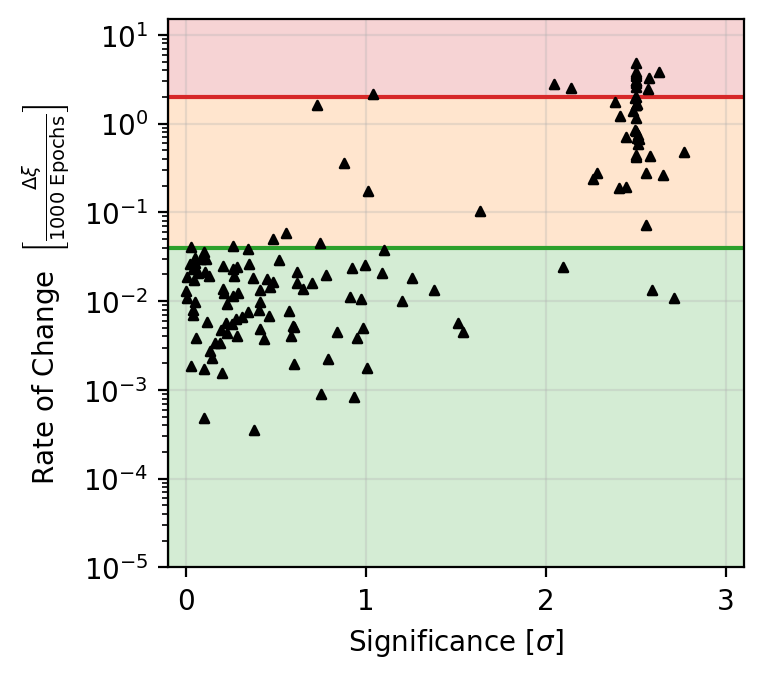

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6.5/1.8, 6/1.8), dpi=200)
fig.tight_layout(w_pad=5)

# dm in 5 Epochs 
# 200 * dm in 1000 Epochs
ax.scatter(np.abs(all_models_thresholded_trend_significance_values), np.abs(all_models_thresholded_trend_speed_values) * 200, color='black', marker='^', s=10, zorder=3);
# ax.scatter(np.abs(sin_models_thresholded_trend_significance_values), np.abs(sin_models_thresholded_trend_speed_values) * 100, color='tab:blue', marker='^', s=10, zorder=3);
# ax.scatter(np.abs(any_models_thresholded_trend_significance_values), np.abs(any_models_thresholded_trend_speed_values) * 100, color='tab:orange', marker='s', s=10, zorder=3);
# ax.scatter(np.abs(none_models_thresholded_trend_significance_values), np.abs(none_models_thresholded_trend_speed_values) * 100, color='tab:red', marker='x', s=10, zorder=3);
ax.set_ylabel(r'Rate of Change  $\left[\frac{\Delta \xi}{1000 \,\,\mathrm{Epochs}}\right]$'); ax.set_xlabel(r'Significance $[\sigma]$'); ax.set_yscale('log'); ax.grid(alpha=0.3, zorder=1);
ax.axhspan(1e-6, reasonable_cutoff, color='tab:green', label='Coefficient Converged', alpha=0.2);
ax.axhspan(reasonable_cutoff, unreasonable_cutoff, color='tab:orange', label='Convergence Debatable', alpha=0.2);
ax.axhspan(unreasonable_cutoff, 100, color='tab:red', label='Coefficient Not Converged', alpha=0.2);
ax.axhline(unreasonable_cutoff, color='tab:red', label=r'$|\Delta \xi|$ = 0.2 in 100 Epochs')
ax.axhline(reasonable_cutoff, color='tab:green', label=r'$|\Delta \xi|$ = 0.2 in 5000 Epochs')
ax.set_ylim(1e-5, 15), ax.set_xlim(-0.1, 3.1); 
# ax.legend(loc='lower right'); 